In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Classifier
from sklearn.model_selection import train_test_split

# Imbalance - oversampling of the minority class
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer,  make_column_selector as selector
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve,roc_auc_score

In [85]:
df = pd.read_csv('Churn_In_Telecom.csv', low_memory=False)

Functions

Model Evaluation

In [ ]:
def model_evaluation(model, X_train, y_train, X_test, y_test):
    # Predict labels for X_train and y_train 
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # CALCULATION
    ###################################################################
    # Calculate the evaluation metrics for train data
    train_acc = accuracy_score(y_train, y_train_pred)
    train_prec = precision_score(y_train, y_train_pred)
    train_rec = recall_score(y_train, y_train_pred)
    train_f1 = f1_score(y_train, y_train_pred)
    train_cm = confusion_matrix(y_train, y_train_pred)

    # Calculate the evaluation metrics for test data
    test_acc = accuracy_score(y_test, y_test_pred)
    test_prec = precision_score(y_test, y_test_pred)
    test_rec = recall_score(y_test, y_test_pred)
    test_f1 = f1_score(y_test, y_test_pred)
    test_cm = confusion_matrix(y_test, y_test_pred)
    
    ###################################################################
    
    # PLOT & SUMMARY (training)
    ###################################################################
    # Confusion Matrix (training)
    sns.heatmap(train_cm, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix - Training Data")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()
    
    # Evaluation metrics (training)
    print("Training Data:")
    print("Accuracy:", train_acc)
    print("Precision:", train_prec)
    print("Recall:", train_rec)
    print("F1-score:", train_f1)
    ###################################################################

    # PLOT & SUMMARY (test)
    ###################################################################
    # Confusion Matrix (test)
    sns.heatmap(test_cm, annot=True, fmt="d", cmap="Reds")
    plt.title("Confusion Matrix - Test Data")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()

    # Evaluation metrics (test)
    print("\nTest Data:")
    print("Accuracy:", test_acc)
    print("Precision:", test_prec)
    print("Recall:", test_rec)
    print("F1-score:", test_f1)
    ###################################################################


In [ ]:
df.info()

In [ ]:
df.head()

In [ ]:
df.shape

In [86]:
# Replace column spaces with underscore

df.columns = df.columns.str.replace(' ','_')

In [87]:
# Remove unnecessary columns
df = df.drop('phone_number', axis=1)

In [ ]:
# Updated DataFrame (renamed columns / dropped columns)
df.head(3)

In [ ]:
# Convert churn to binary
#df['churn'] = df['churn'].map({True:1 ,False:0})
#df['churn'] = df['churn'].astype(int)

In [ ]:
df['churn'].dtype

In [ ]:
df.info()

In [ ]:
# Change international_plan and voice_mail_plan into binary values (0 and 1)

def binary_swap(column):
    df[column] = df[column].apply(lambda x: 1 if x == "yes" else (0 if x == "no" else x))
    
    return df

binary_swap('international_plan')
binary_swap('voice_mail_plan')

In [ ]:
# Plot account_length
print('Account Length')
df.account_length.plot(kind='hist')

In [ ]:
# Plot churn
print('Churn')
df.churn.value_counts().plot(kind='bar')

In [ ]:
false_churn_percentage, true_churn_percentage = df.churn.value_counts(True)

In [88]:
# False churn percentage
print('False churn percentage: ', false_churn_percentage * 100)
print('False churns: ', df.churn.value_counts().values[0])

print( ' ')

# True churn percentage
print('True churn percentage: ', true_churn_percentage * 100)
print('True churns: ', df.churn.value_counts().values[1])

# Churn rate
churn_rate = pd.DataFrame(df.churn.value_counts(True))

False churn percentage:  85.5085508550855
False churns:  2850
 
True churn percentage:  14.491449144914492
True churns:  483


In [ ]:
churn_rate

In [ ]:
# Churn by area code

plt.figure(figsize=(10, 8))
sns.barplot(data=df, x='area_code', y='churn', hue='churn', estimator=lambda c: len(c) / len(df) * 100)
plt.xlabel('Area Code')
plt.ylabel('Rate of Churn')
plt.title('Rate of Churn by Area Code')
plt.show()


In [ ]:
# Plot churn by rates

fig, ax = plt.subplots(figsize=(8,8))

sns.barplot(x = [0, 1], y = 'churn', data = churn_rate, ax = ax)
plt.title('Rate of Customer Churn vs Retention')
ax.tick_params(axis = 'both')
plt.xlabel('Retention vs Churn')
plt.ylabel('Rate of Churn')
ax.set_xticklabels(['Retention', 'Churn'])
plt.tight_layout()


In [ ]:
# The dataset seems imbalanced when analyzing the churn rates
# There seems to be more values in False than in True

In [ ]:
# Churn by State

plt.figure(figsize=(12, 4))
states_churn = df[df['churn'] == True]['state'].value_counts().index
sns.countplot(data=df, x='state', hue='churn', order=states_churn)
plt.xlabel('State')
plt.ylabel('Customer Count')
plt.title('Churn by State')
plt.xticks(rotation=90)
plt.legend(title='Churn', loc='upper right')
plt.show()

In [ ]:
df.describe()

In [ ]:
# Histogram excluding churn
df.drop('churn', axis=1).hist(figsize=(18,18), bins = 'auto');

In [ ]:
# Heatmap displaying correlation between columns
sns.heatmap(df.corr(), annot=True, fmt=".2f", linewidths=0.3)

## <font color = 'red'> Modeling Preparation </font>

In [89]:
# Convert churn to binary
df['churn'] = df['churn'].map({True:1 ,False:0})
df['churn'] = df['churn'].astype(int)

#### Categorical / Numerical 

                    ______________________Distinguish Categorical / Numerical______________________ 

- To help better organize the data and feed it directly into the model, we need to understand the Categorical and Numerical columns we want to further explore.

    - The categorical columns are those with various categories given a numerical value that can be interpreted by the algorithm, when One Hot Code is applied.

    - The numerical columns can be standardized to avoid any bias in the predictions due to different ranges in the training data  

In [90]:
categorical = ['state','international_plan', 'voice_mail_plan', 'area_code']
categorical

['state', 'international_plan', 'voice_mail_plan', 'area_code']

In [91]:
numerical = df.select_dtypes(include='int64').drop('area_code', axis=1).columns
numerical

Index(['account_length', 'number_vmail_messages', 'total_day_calls',
       'total_eve_calls', 'total_night_calls', 'total_intl_calls',
       'customer_service_calls'],
      dtype='object')

    ______________________________________________________________________________________________________________________

#### One Hot Encode

                                  __________________One Hot Encode__________________

In [92]:
# One Hot Encode
df = pd.get_dummies(df, columns=categorical, drop_first=True)

df.head()

,account_length,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,...,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY,international_plan_yes,voice_mail_plan_yes,area_code_415,area_code_510
0,128,25,265.1,110,45.07,197.4,99,16.78,244.7,91,...,0,0,0,0,0,0,0,1,1,0
1,107,26,161.6,123,27.47,195.5,103,16.62,254.4,103,...,0,0,0,0,0,0,0,1,1,0
2,137,0,243.4,114,41.38,121.2,110,10.30,162.6,104,...,0,0,0,0,0,0,0,0,1,0
3,84,0,299.4,71,50.90,61.9,88,5.26,196.9,89,...,0,0,0,0,0,0,1,0,0,0
4,75,0,166.7,113,28.34,148.3,122,12.61,186.9,121,...,0,0,0,0,0,0,1,0,1,0


In [93]:
numerical_cols = numerical_columns

# Create a StandardScaler object
scaler = StandardScaler()

# Scale the numerical features
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])
df.head()

,account_length,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,...,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY,international_plan_yes,voice_mail_plan_yes,area_code_415,area_code_510
0,0.676489,1.234883,265.1,0.476643,45.07,197.4,-0.055940,16.78,244.7,-0.465494,...,0,0,0,0,0,0,0,1,1,0
1,0.149065,1.307948,161.6,1.124503,27.47,195.5,0.144867,16.62,254.4,0.147825,...,0,0,0,0,0,0,0,1,1,0
2,0.902529,-0.591760,243.4,0.675985,41.38,121.2,0.496279,10.30,162.6,0.198935,...,0,0,0,0,0,0,0,0,1,0
3,-0.428590,-0.591760,299.4,-1.466936,50.90,61.9,-0.608159,5.26,196.9,-0.567714,...,0,0,0,0,0,0,1,0,0,0
4,-0.654629,-0.591760,166.7,0.626149,28.34,148.3,1.098699,12.61,186.9,1.067803,...,0,0,0,0,0,0,1,0,1,0


    ______________________________________________________________________________________________________________________

#### Defining X and y variables

                                __________________Define X and y variables __________________

- To fit the data into a learning model, we need to convert the categories into dummy variables, which is denoted as binary in this case (0, 1). So to use the predictors (X-variable) in a model, for this case, a logistic regression, we must have dummy variables.  

In [94]:
# Defining X and y-variables
X = df.drop('churn', axis = 1)
y = df['churn']

In [ ]:
# Converting categorical values using get_dummies
#X = pd.get_dummies(X)
X.head()

In [ ]:
X

#### Train, Test, Split

                               _____________________Train-Test Split_____________________

- Making use of the Train-Test Split is vital as its used to estimate the performance of the learning model for predictions, when comparing the algorithms for the predictive model at hand.

In [95]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

In [ ]:
X_train

In [ ]:
X_train.info()


    ______________________________________________________________________________________________________________________

#### One-Hot Encoder (WORK IN PROGRESS)

                                                   One Hot Encoder

In [ ]:
categorical_columns = ['state','international_plan', 'voice_mail_plan', 'area_code']

In [ ]:
def one_hot_encode(df, columns, drop_first=True):
    return pd.get_dummies(df, columns=columns, drop_first=drop_first)
columns_to_encode = categorical_columns
# one hot encode the categorical columns in the df
df = one_hot_encode(df, columns_to_encode)
# display the first 5 rows and columns to confirm
df.head()

In [ ]:
#df['state'] = df['state'].astype(float)

In [ ]:
#df.info()

In [ ]:
# Instantiate
ohe = OneHotEncoder(sparse = False, handle_unknown = "ignore")

# Fit 
ohe.fit(X_train[['state']])

# access the column names of the states
col_names = ohe.categories_[0]

# make a df with encoded states
train_state_encoded = pd.DataFrame(ohe.transform(X_train[["state"]]), 
                               index = X_train.index, 
                               columns = col_names)

# combine encoded states with X_t and drop old 'state' column
X_train = pd.concat([X_train.drop("state", axis = 1), train_state_encoded], axis = 1)

#### Standard Scaler

                                                  StandardScaler()

In [ ]:


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

# Convert to Dataframe
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)
X_train_scaled.head()

    ______________________________________________________________________________________________________________________

#### Resampling Data points (SMOTE)

                   ____________________________RESAMPLING - USING SMOTE____________________________

                                                        SMOTE

- We use the SMOTE, which stands for Synthetic Minority Oversampling Technique. This is a algorithm design to oversample the minority class. Since there is an imbalance in class 1 (True), we will need to apply SMOTE to generate synthetic data points that is based off the original data points.

- After applying SMOTE, the Synthetic sample class distribution is now 50/50, meaning the distribution of data points are now balanced.


In [96]:
#instantiate SMOTE 
sm = SMOTE(k_neighbors=5, random_state=123)
# fit sm on the training data
X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)
# print training data set before over sampling
print('Before resampling, the shape of X_train: {}'.format(X_train.shape))
print('Before resampling, the shape of y_train: {}'.format(y_train.shape)) 
# print training data set after over sampling
print('After resampling, the shape of X_train_resampled: {}'.format(X_train_resampled.shape))
print('After resampling, the shape of y_train_resampled: {}'.format(y_train_resampled.shape))
y_train_resampled.value_counts()

Before resampling, the shape of X_train: (2499, 69)
Before resampling, the shape of y_train: (2499,)
After resampling, the shape of X_train_resampled: (4282, 69)
After resampling, the shape of y_train_resampled: (4282,)


1    2141
0    2141
Name: churn, dtype: int64

In [ ]:
# We need to use SMOTE to oversample the minority class, which in this case is True for churn
print('Imbalance of classes by rate')
print(churn_rate)

smote = SMOTE(random_state = 42)
X_train_resampled, y_train_resampled = smote.fit_resample(X, y)

# Preview synthetic sample class distribution
print('-----------------------------------------')
print('Synthetic sample class distribution: \n')
print(pd.Series(y_train_resampled).value_counts()) 

######  <font color = 'gray'> Before and After comparison of shape and class distribution

<font color= 'red'><b> Before Resampling </b></font>

In [ ]:
# Class distribution
print('Class distribution: ')
print(y_train.value_counts())
print(' ')


# Shape
print('X-train: ', X_train.shape)
print('y-train: ', y_train.shape)

<font color= 'green'><b> After Resampling (SMOTE)</b> </font>

In [ ]:
# Class distribution
print('Class distribution: ')
print(y_train_resampled.value_counts())
print(' ')

# Shape
print('Shape:')
print('X-train: ', X_train_resampled.shape)
print('y-train: ', y_train_resampled.shape)

    ______________________________________________________________________________________________________________________

#### Logistic Regression using Resampled Data points

                                                Logistic Regression

- This classification model is used to predict a binary outcome based on prior data observations, well suited for predicting customer churn (0, 1). Using churn as the dependent variables, y, we are able to see the relationships with the independent variables in X.

In [100]:
# create the logistic Regression model
# use LogisticRegression from scikit learn
# Instantiate the model
logreg = LogisticRegression(solver='liblinear', random_state=42)

# Fit the model
# train the model on training data
logreg.fit(X_train_resampled, y_train_resampled)

# predict the test
y_test_pred = logreg.predict(X_test)
# Assuming you have a trained model called 'model' and test data 'X_test'
y_train_pred = logreg.predict(X_train_resampled)

In [98]:
# Resampled using SMOTE
logreg = LogisticRegression(random_state=42)
logreg.fit(X_train_scaled, y_train_resampled)

print('Training Data:\n', classification_report(y_train_resampled, logreg.predict(X_train_scaled)))
print('Testing Data:\n', classification_report(y_test, logreg.predict(X_test_scaled)))

ValueError: Found input variables with inconsistent numbers of samples: [5700, 4282]

#### Model Evaluation

                                                 Model Evaluation

- To get a better indication of the performance of the Logistic Regression Model, we will define a function called model_evaluation, that will calculate:
        - Accuracy
        - Recall
        - Precision
        - F1-Score
  
  Then, it will plot a Confusion Matrix for the trained and test data, and result with a summary at the bottom of each matrix, showing us the values of the respective metrics listed above.

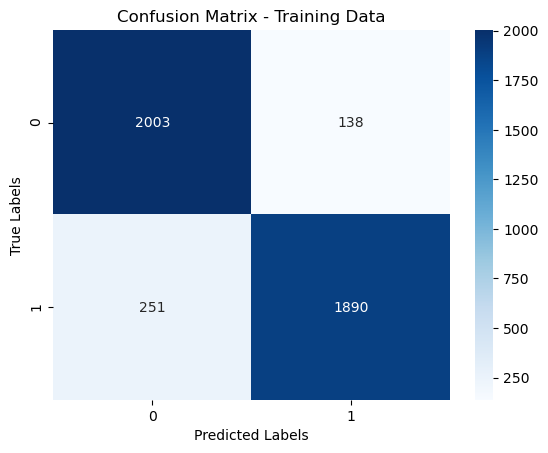

Training Data:
Accuracy: 0.9091546006539001
Precision: 0.9319526627218935
Recall: 0.8827650630546474
F1-score: 0.9066922523386903


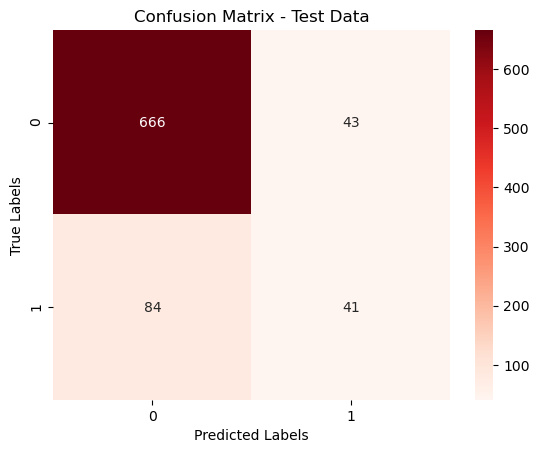


Test Data:
Accuracy: 0.8477218225419664
Precision: 0.4880952380952381
Recall: 0.328
F1-score: 0.3923444976076555


In [101]:
model_evaluation(logreg, X_train_resampled, y_train_resampled, X_test, y_test)

    ______________________________________________________________________________________________________________________

In [ ]:
X_numeric_cols = ['account_length','number_vmail_messages',
       'total_day_minutes', 'total_day_calls', 'total_day_charge',
       'total_eve_minutes', 'total_eve_calls', 'total_eve_charge',
       'total_night_minutes', 'total_night_calls', 'total_night_charge',
       'total_intl_minutes', 'total_intl_calls', 'total_intl_charge',
       'customer_service_calls']
X_categorical_cols = ['state', 'area_code','international_plan', 'voice_mail_plan']
X_ignore_cols = ['phone_number']
y_target_col = 'churn'

In [ ]:
# Train / test / split: test size.  
test_size = .35

def cross_val_and_print_results_on_model(model_name,pipe, X_tr, y_tr, X_te, y_te):
    results = cross_val_score(pipe, X_tr, y_tr, cv=10)
    y_hat = pipe.fit(X_tr, y_tr).predict(X_te)
    print(model_name + ":")
    print(f"Training data - accuracy:          {round(np.mean(results), 4)}")
    print(f"Test data - accruacy:              {round(accuracy_score(y_te, y_hat), 4)}")
    matrix=classification_report(y_te, y_hat)
    print("Classification report:\n", matrix)
    
    
def grid_search_and_print_results(params, pipe, X_tr, y_tr, X_te, y_te):
    gs = GridSearchCV(estimator=pipe,param_grid=params, cv=5, verbose=1)
    gs.fit(X_tr, y_tr)
    print("Results:")
    print("- Best params: ", gs.best_params_)
    print("- Best score: ", gs.best_score_)
    print("- Test data score: ", gs.best_estimator_.score(X_te, y_te))

In [ ]:
X = df.drop(X_ignore_cols + [y_target_col], axis=1)
y = df[y_target_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=test_size)

In [ ]:
df.churn.value_counts(normalize=True)

In [ ]:
# Numerical column transformers
num_pipe = Pipeline([('ss',StandardScaler())])

# Categorical column transformers
cat_pipe = Pipeline([
    ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))
])
CT = ColumnTransformer(transformers=[
    ('num_trans', num_pipe, X_numeric_cols),
    ('cat_trans', cat_pipe, X_categorical_cols)
],remainder='passthrough')

In [ ]:
model_name = "Baseline - Dummy Classifer"
model = DummyClassifier(strategy='most_frequent', random_state=42)
pipe = Pipeline([ ('ct',CT), ('model', model) ])
cross_val_and_print_results_on_model(model_name, pipe, X_train, y_train, X_test, y_test)

In [ ]:
model_name = "Logistic Regression"
model = LogisticRegression(random_state=42)
pipe = Pipeline([ ('ct',CT), ('model', model) ])
cross_val_and_print_results_on_model(model_name, pipe, X_train, y_train, X_test, y_test)